# Data science with geolocation data

<i>By Diego Ramallo</i>


<img src="https://dl.dropboxusercontent.com/u/59776078/data_science/data_science/map-525349_1920.png" alt="Drawing" style="width: 350px;"/>

Here I will play around with some geolocation data and see if I can visualize it, calculate travel times with it, and hopefully, test some ML on it.

A good source for this type of data is the [SF OpenData](#https://data.sfgov.org/Transportation/NextMuni-vehicle-prediction-data/fam4-k899) repository which has a MUNI dataset. This can give me a good resource for mapping locations around San Francisco.

[Accessing Data](#Accessing Data)

[Mapping Locations Using the Google Maps API](#Mapping Locations Using the Google Maps API)

[Formatting Data](#Formatting Data)

[Visualize Locations](#Visualize Locations)

[Segmenting Riders into Clusters](#Segmenting Riders into Clusters)

[Getting travel times using the GMaps Distance Matrix API](#Getting travel times using the GMaps Distance Matrix API)

## Accessing Data

<a id='Accessing Data'></a>

In [35]:
import numpy as np#Math library
import pandas as pd#Table library
import matplotlib.pyplot as plt#Plotting library
import pandas as pd
import warnings
import seaborn as sns#Plotting library
warnings.filterwarnings('ignore')#Gets rid of popup warnings
%matplotlib nbagg

In [53]:
#Take subset of data to generate locations for drivers and riders using
#the MUNI stop data file
locData= pd.read_table('google_transit/stops.txt', delimiter= ',')

riders= locData[['stop_id','stop_lat','stop_lon']].sample(n= 100, random_state= 42)
drivers= locData[['stop_id','stop_lat','stop_lon']].sample(n= 20, random_state= 24)
destinations= locData[['stop_id','stop_lat','stop_lon']].sample(n= 20, random_state= 35)
riders.head(5)

,stop_id,stop_lat,stop_lon
354,3283,37.764579,-122.428523
3588,6601,37.789062,-122.410316
416,3346,37.762701,-122.395422
2694,5706,37.775710,-122.446360
3277,6290,37.794180,-122.400282


## Mapping Locations Using the Google Maps API

<a id='Mapping Locations Using the Google Maps API'></a>

It's really nice that Google allows you to use Google Maps API library to visualize objects, but it does require [generating an API key](https://developers.google.com/maps/get-started/) and enabling the specific API's that you'll use (at a minimum the JavaScript API).

Finally, to enable the maps widget in a Jupyter notebook, I'll need to install the gmaps library. Here are the [installation instructions](#http://jupyter-gmaps.readthedocs.io/en/latest/).

In [62]:
#Import gmaps for embedding google maps in a jupyter notebook and summon API key
import os
import gmaps

#The gmaps installation instructions mentioned that your API key
#should not be shared so I instead listed it in my .bash_profile
#document and am calling it from here
gmaps.configure(api_key=os.environ['GOOGLE_API_KEY'])

## Formatting Data

<a id='Formatting Data'></a>

In order to relay the information to gmaps, we'll need to reformat the data in our pandas dataframes to a list of lat/long tuples to be able to read the coordinates.

In [55]:
#Format driver lat/long to list of tuples to use them
#with the gmaps library
driverData = drivers[['stop_lat','stop_lon']]
driverData= [tuple(i) for i in driverData.values]
driverData[0:5]

#Same for riders
riderData = riders[['stop_lat','stop_lon']]
riderData= [tuple(i) for i in riderData.values]
riderData[0:5]

#Let's give the riders destinations
destData = destinations[['stop_lat','stop_lon']]
destData= [tuple(i) for i in destData.values]
destData[0:5]

[(37.742646000000001, -122.487545),
 (37.805108000000004, -122.425409),
 (37.740884000000001, -122.46593799999999),
 (37.749039000000003, -122.468369),
 (37.751187000000002, -122.505366)]

## Visualize Locations

<a id='Visualize Locations'></a>

In [39]:
#Define plot layers for drivers and riders
#Make driver markers green and rider markers red
driverLayer = gmaps.symbol_layer(
    driverData, fill_color="green", stroke_color="green", scale=2)

riderLayer= gmaps.symbol_layer(
    riderData, fill_color="red", stroke_color="red", scale=2)

In [40]:
#Initialize map object to plot points 
sfMap= gmaps.Map()

#Apply layers to map
sfMap.add_layer(driverLayer)
sfMap.add_layer(riderLayer)

#Could also generate heatmap with line below
#heatmap_layer = gmaps.Heatmap(data=driverData)

#Show map
sfMap

Sweet it worked! :) It doesn't look like it shows up on Github but it's there!

## Segmenting Riders into Clusters

<a id='Segmenting Riders into Clusters'></a>

Now that I know where the riders are and where the drivers are, I'll try to segment them to optimize their locations. 

To begin with, I will assume that I have 20 clusters since I have 20 drivers and use K-Means as a first pass segmentation tool. This will cluster riders based on their distance to the drivers.

In [41]:
len(driverData)

20

In [42]:
#Import kmeans
from sklearn.cluster import KMeans

#Initialize kmeans object, making sure to specify INITIAL cluster
#centroids as driverData (as an array)
kmeans= KMeans(n_clusters= len(driverData), init= np.array(driverData))

#Apply kmeans clustering and look at the labels
kmeans.fit(riderData)
kmeans.labels_

array([ 8,  1,  9,  0,  1,  3,  7, 10,  6, 13,  2, 13, 10,  6, 18,  5, 13,
       17, 17,  0, 11,  7,  5,  2,  7,  5,  2,  1, 16, 15,  6, 13,  9,  2,
       19,  7, 13, 11, 12, 11,  6,  7,  7,  1,  6, 13,  3,  1,  3,  8,  2,
       15, 10, 19,  8, 15,  1,  6, 19,  2,  2,  1, 13,  3,  3,  5,  2, 18,
       10,  6,  9, 10,  4,  6,  1,  8,  9,  1,  9, 13, 17,  6,  0,  4,  3,
        5,  1,  4,  6,  2, 14,  9, 13,  1,  8,  0,  8, 11, 19, 10], dtype=int32)

Excellent, now that we've clustered the riders, let's see how they were distributed with a histogram.

<IPython.core.display.Javascript object>


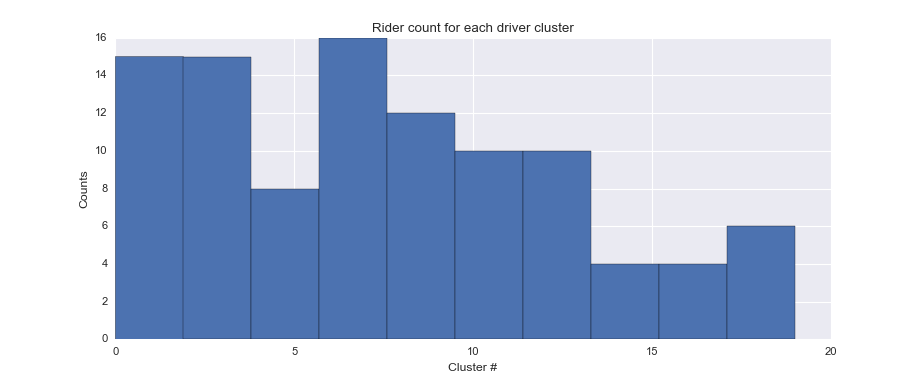

In [44]:
plt.hist(kmeans.labels_)
plt.xlabel('Cluster #')
plt.ylabel('Counts')
plt.title('Rider count for each driver cluster')

Looks pretty well distributed. There were some cars that were far from everything else so we wouldn't expect them to get an equal # of riders. Let's see where the final centroids were.

In [45]:
#Get centroids, turn them into a list of tuple pairs
newCentroids= kmeans.cluster_centers_
newCentroids= map(tuple,newCentroids)

centroidLayer= gmaps.symbol_layer(
    newCentroids, fill_color=None, stroke_color="yellow", scale=2)

In [86]:
#Plot the new centroids on map
sfMap.add_layer(driverLayer)
sfMap.add_layer(centroidLayer)
sfMap

Ok cool, now that I've divided the data up. I need to plot them out by random colors. I have a couple more things to do: 

* <strong>Get travel times</strong>: Need to extract travel times using the Google Maps Distance Matrix API to find the closest locations. Getting the distance (either euclidean or route distance) are options, but assuming we'll drive, travel time is a much better indicator of how far two locations are. The shorter travel time the better.

* <strong>Plan travel route</strong>: Given an initial location and a list of destinations, we'll find the nearest destination after each pickup based on travel time to order our pickup locations most efficiently. 

## Getting travel times using the GMaps Distance Matrix API

<a id='Getting travel times using the GMaps Distance Matrix API'></a>

To test out the API, let's first take some sample data from our destination dataset.

In [73]:
origLat= riderData[0][0]
origLong= riderData[0][1]

destLat= destData[0][0]
destLong= destData[0][1]

In [85]:
import googlemaps
import urllib
import json

#URL to request distance (travel time) from googlemaps api
url = 'https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&'

#URL plus arguments and parameters for sample origins and destination 
fullURL= url+'origins='+str(origLat)+','+str(origLong)+'&destinations='+str(destLat)+','+str(destLong)+'&key='+os.environ['GOOGLE_API_KEY']

#Open url and fetch travel time data 
gmapsData= urllib.urlopen(fullURL)

#Read data
gmapsData= gmapsData.read()
jsonData= json.loads(str(gmapsData))

#Print contents of json data
print json.dumps(jsonData)

{"status": "OK", "rows": [{"elements": [{"duration": {"text": "19 mins", "value": 1138}, "distance": {"text": "4.7 mi", "value": 7621}, "status": "OK"}]}], "origin_addresses": ["3399 16th St, San Francisco, CA 94114, USA"], "destination_addresses": ["2399 30th Ave, San Francisco, CA 94116, USA"]}


In [127]:
#Check data type
type(jsonData)

dict

In [128]:
#Since it's a dictionary extract only the duration of driving time (default mode of travel)
jsonData['rows'][0]['elements'][0]['duration']['text']

u'19 mins'